# Heart Disease

## Importing Packages

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from ucimlrepo import fetch_ucirepo 

## Preparing the Datasets
### 0. Importing the Datasets
Fetch the 'Heart Disease' dataset from UCI.

In [27]:
heart_disease = fetch_ucirepo(id=45) 

### 1. Setting Up the Training and Test Datasets
We will split the original dataset into 4 different splitting strategies, with the proportion of training and test as follows: 40/60, 60/40, 80/20, and 90/10.

First, we split the original dataset into feature and label columns, as the target we are considering now is 'num'.

In [28]:
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Converting the data to a dataframe for easier manipulation
data = pd.concat([X, y], axis=1)
data = data.dropna()

data.rename(columns={'num': 'label'}, inplace=True)
target = 'label'

data[target] = data[target].apply(lambda x: 1 if x > 0 else 0)
X = data.drop(columns=target)
y = data[target]

Then the feature and label are split into 4 splitting strategies as mentioned above.

In [29]:
training_sizes = {
    "40/60": 0.4,
    "60/40": 0.6,
    "80/20": 0.8,
    "90/10": 0.9,
}

datasets = {}

for ratio, training_size in training_sizes.items():
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y,
        test_size=1-training_size,
        train_size=training_size,
        shuffle=True,
        stratify=y
    )

    datasets[ratio] = (feature_train, feature_test, label_train, label_test)

After splitting the datasets, the visualization of the class distribution is as follows.

#### Original Set

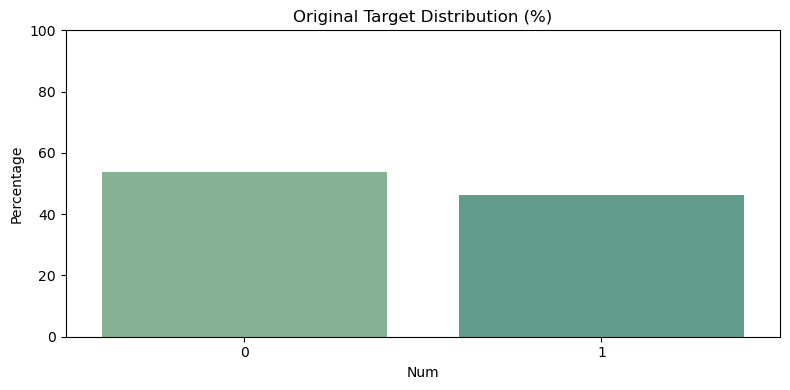

In [30]:
original_pct = y.value_counts(normalize=True) * 100
original_df = pd.DataFrame({
    'Num': original_pct.index.astype(str),
    'Percentage': original_pct.values
})

sns.set_palette('crest')
plt.figure(figsize=(8, 4))
sns.barplot(data=original_df, x='Num', y='Percentage', hue='Num', legend=False)
plt.title('Original Target Distribution (%)')

plt.xlabel('Num')
plt.ylabel('Percentage')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


#### Training Set

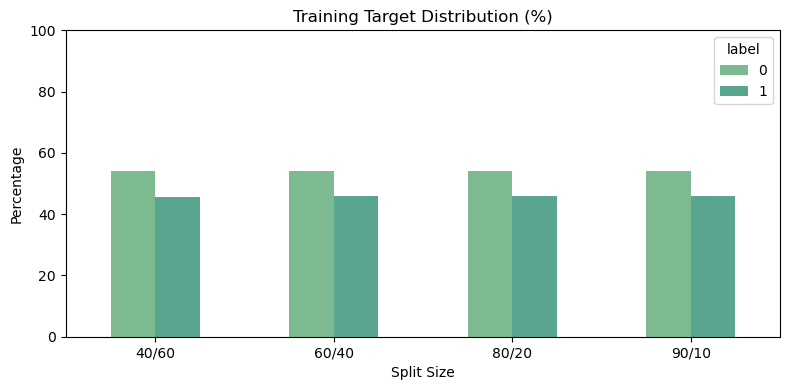

In [31]:
train_distributions = {}

for ratio, (feature_train, feature_test, label_train, label_test) in datasets.items():
    train_pct = label_train.value_counts(normalize=True) * 100
    train_distributions[ratio] = train_pct

train_df = pd.DataFrame(train_distributions).T

train_df.plot(kind='bar', figsize=(8, 4), legend=True)

plt.title("Training Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Test Set

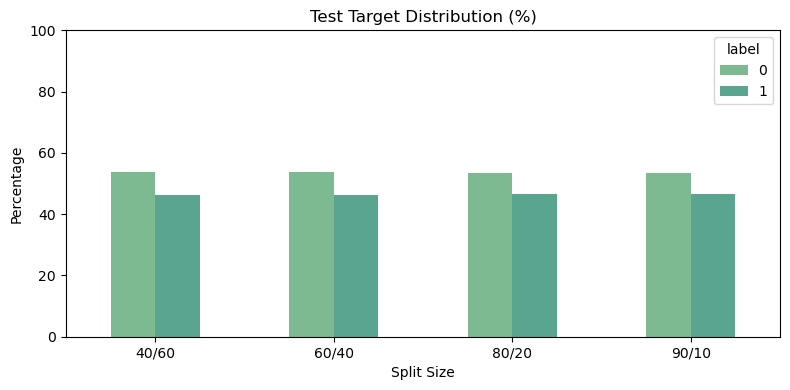

In [32]:
test_distributions = {}

for ratio, (feature_train, feature_test, label_train, label_test) in datasets.items():
    test_pct = label_test.value_counts(normalize=True) * 100
    test_distributions[ratio] = test_pct

test_df = pd.DataFrame(test_distributions).T

test_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Test Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


As can be seen from three plots above, the dataset is relatively balanced across both training and test splits, which indicates that the preparation was appropriate.

### 2. Building the Decision Tree Classifiers

After preparing the datasets, we now fit a Decision Tree Classifier to each training set and visualize the decision tree result.

#### Model Training
We apply the `DecisionTreeClassifier` on each splitted subsets.

In [33]:
models = {}

for ratio, (feature_train, feature_test, label_train, label_test) in datasets.items():
    model = tree.DecisionTreeClassifier(criterion='entropy')
    model.fit(feature_train, label_train)

    models[ratio] = model

#### Visualization
The visualization of the resulting decision trees is processed with Graphviz.

In [34]:
graphs = {}

for ratio, model in models.items():
    dot_data = tree.export_graphviz(model, out_file=None, filled=True, rounded=True)
    graph = graphviz.Source(dot_data)

    graphs[ratio] = graph

Decision Tree Graph for 40/60 splitting.

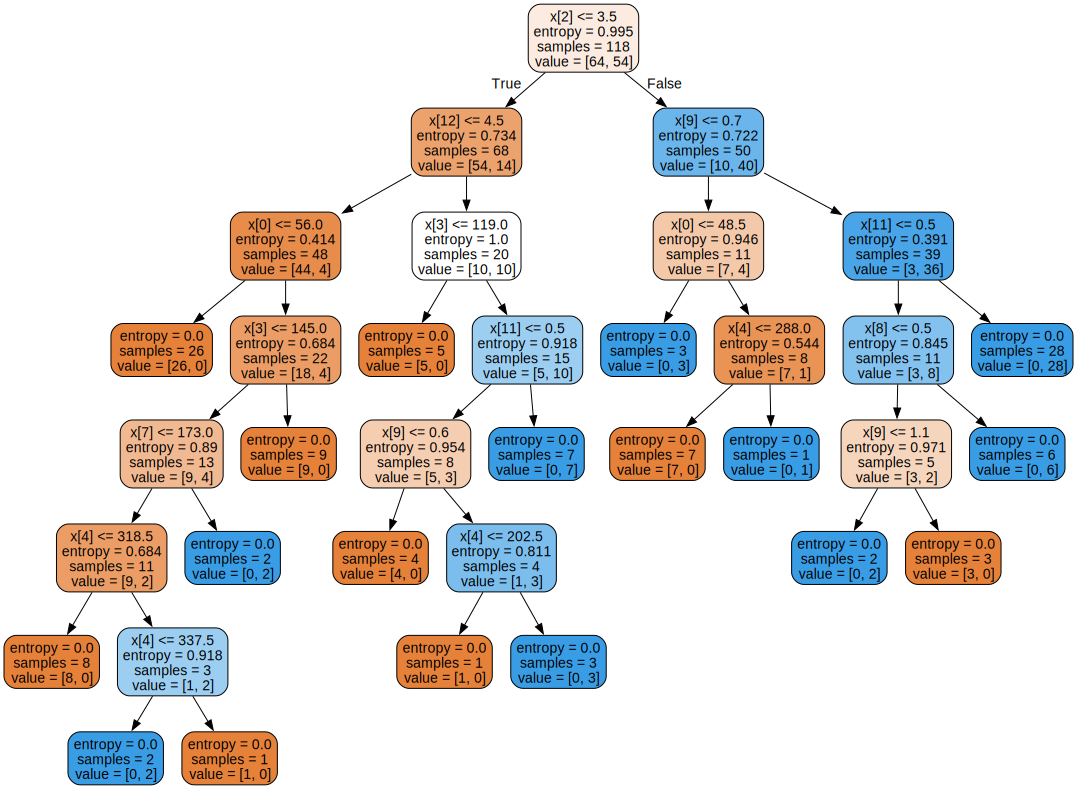

In [35]:
graphs['40/60']

Decision Tree Graph for 60/40 splitting.

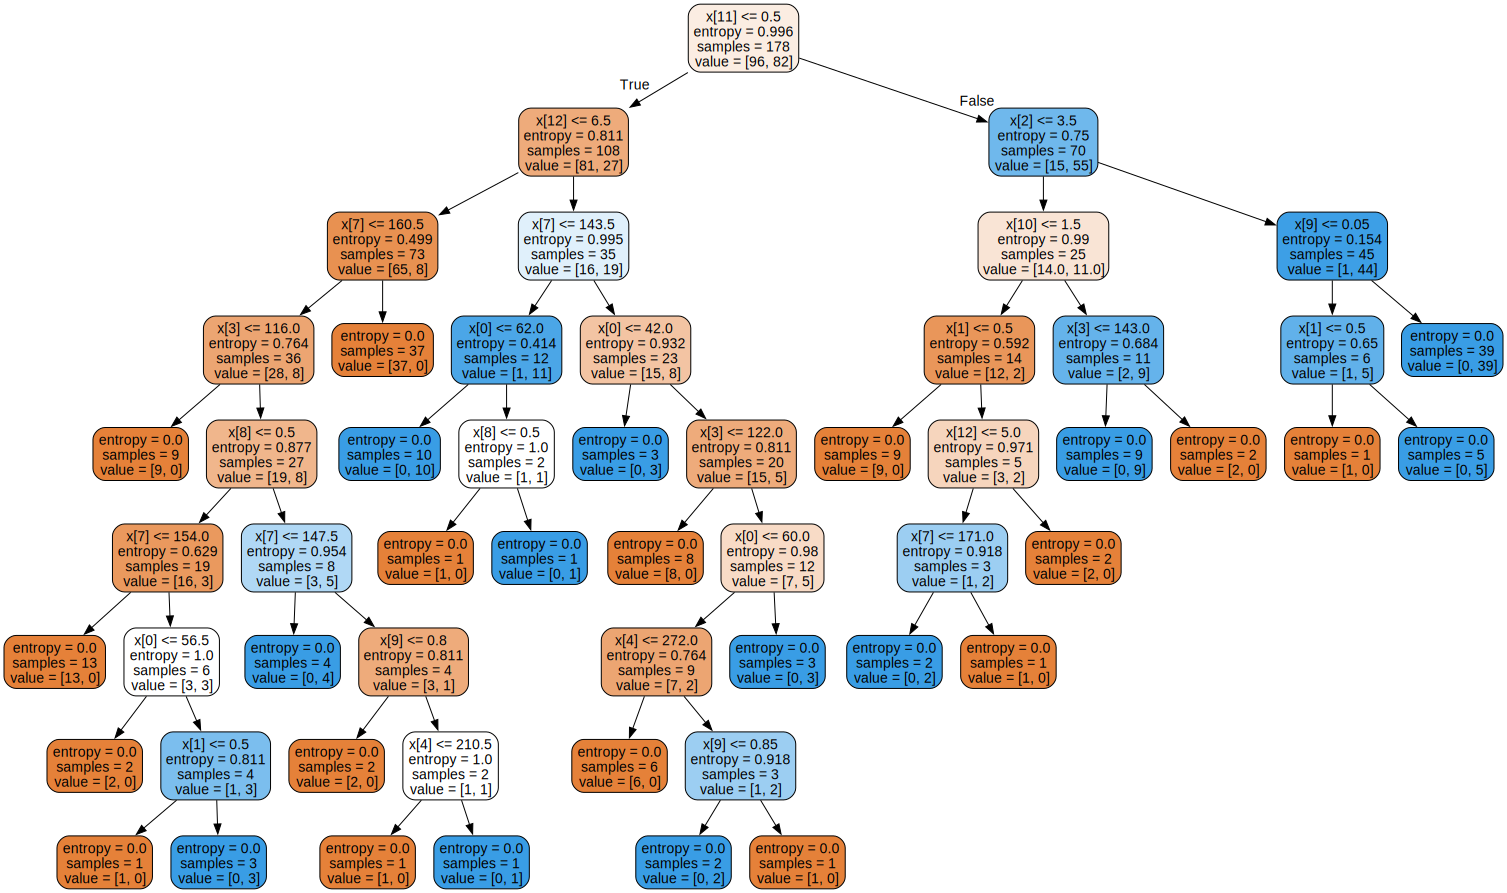

In [36]:
graphs['60/40']

Decision Tree Graph for 80/20 splitting.

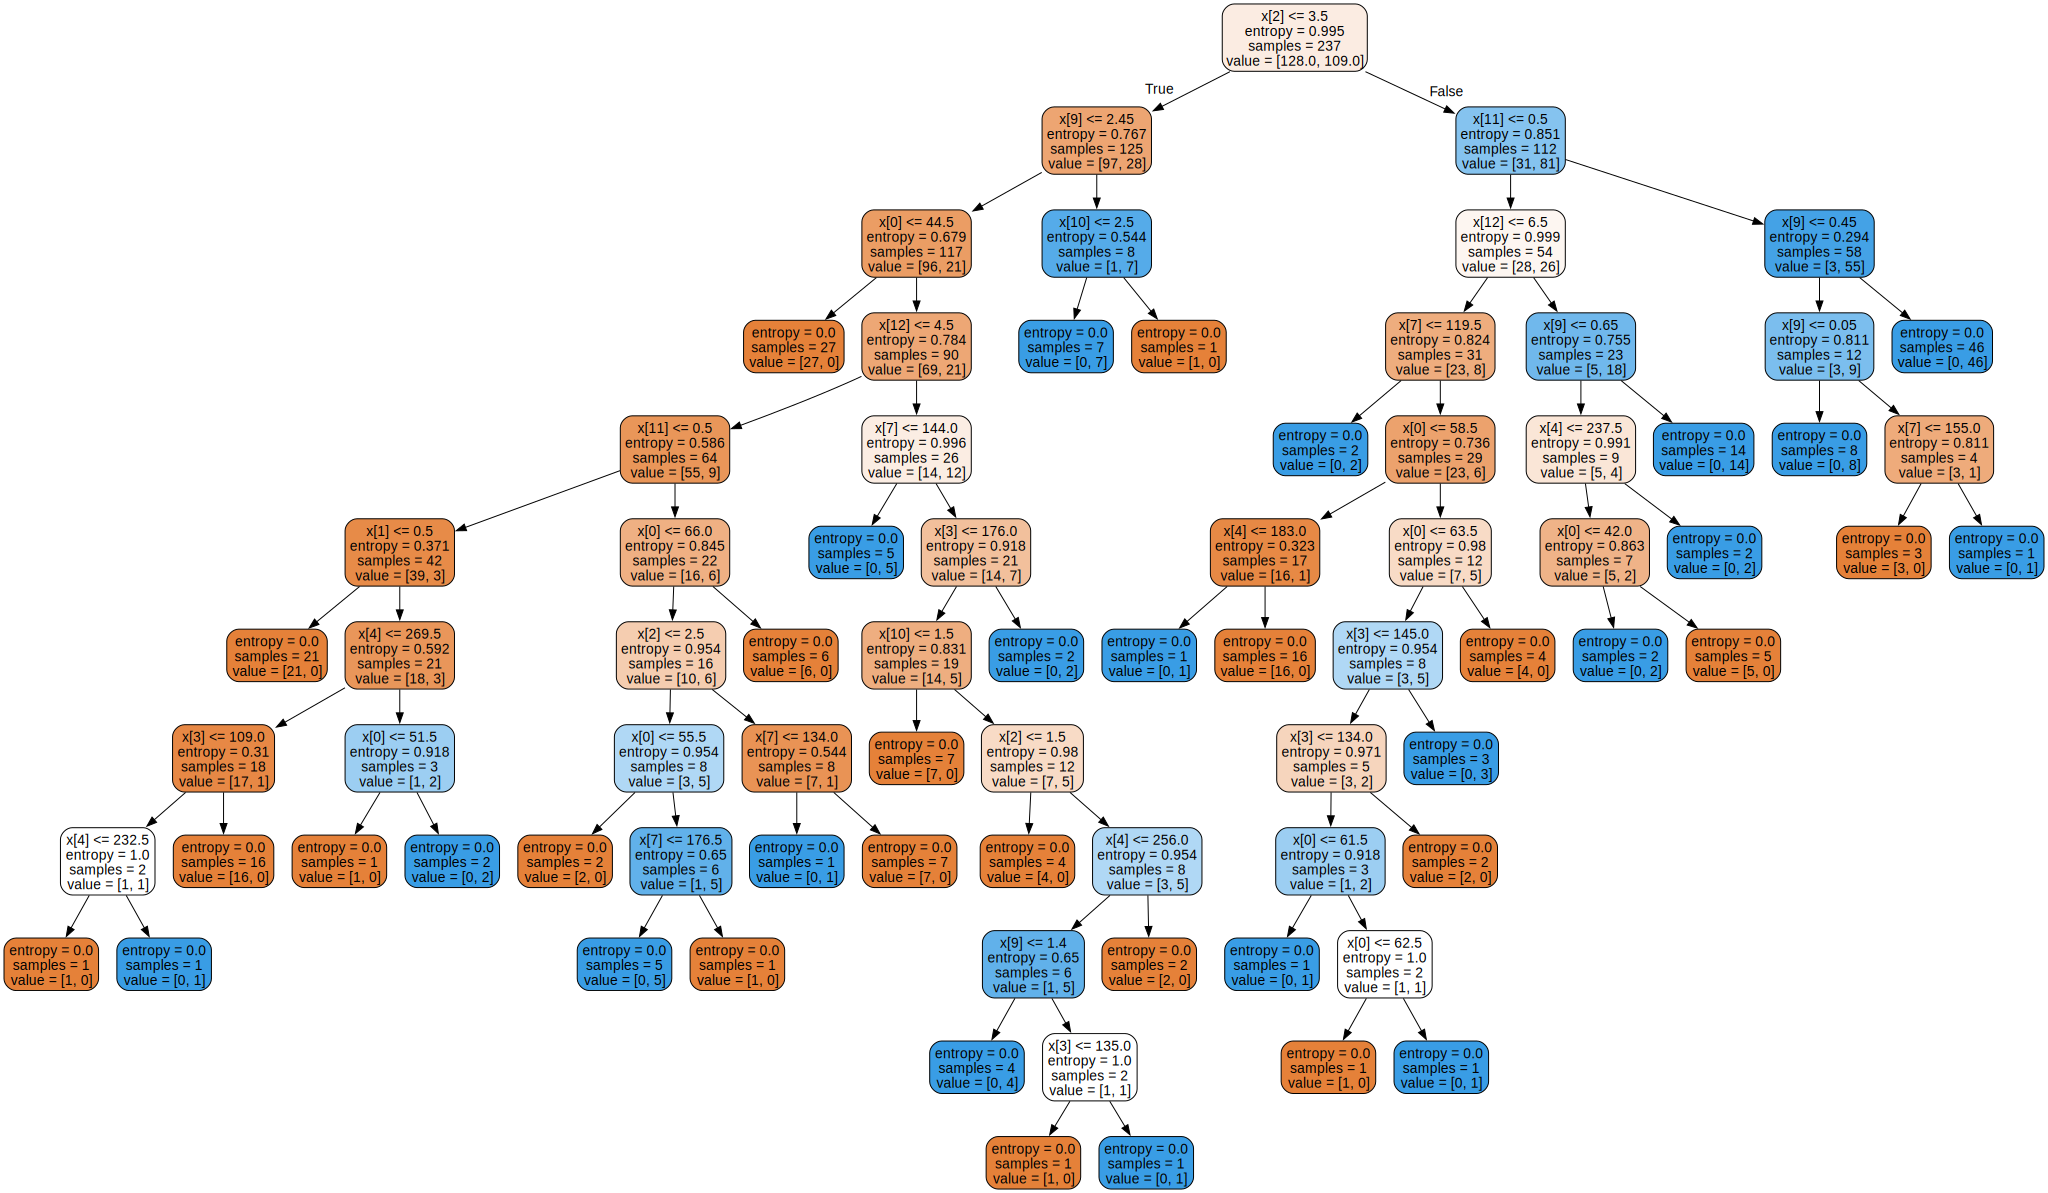

In [37]:
graphs['80/20']

Decision Tree Graph for 90/10 splitting.

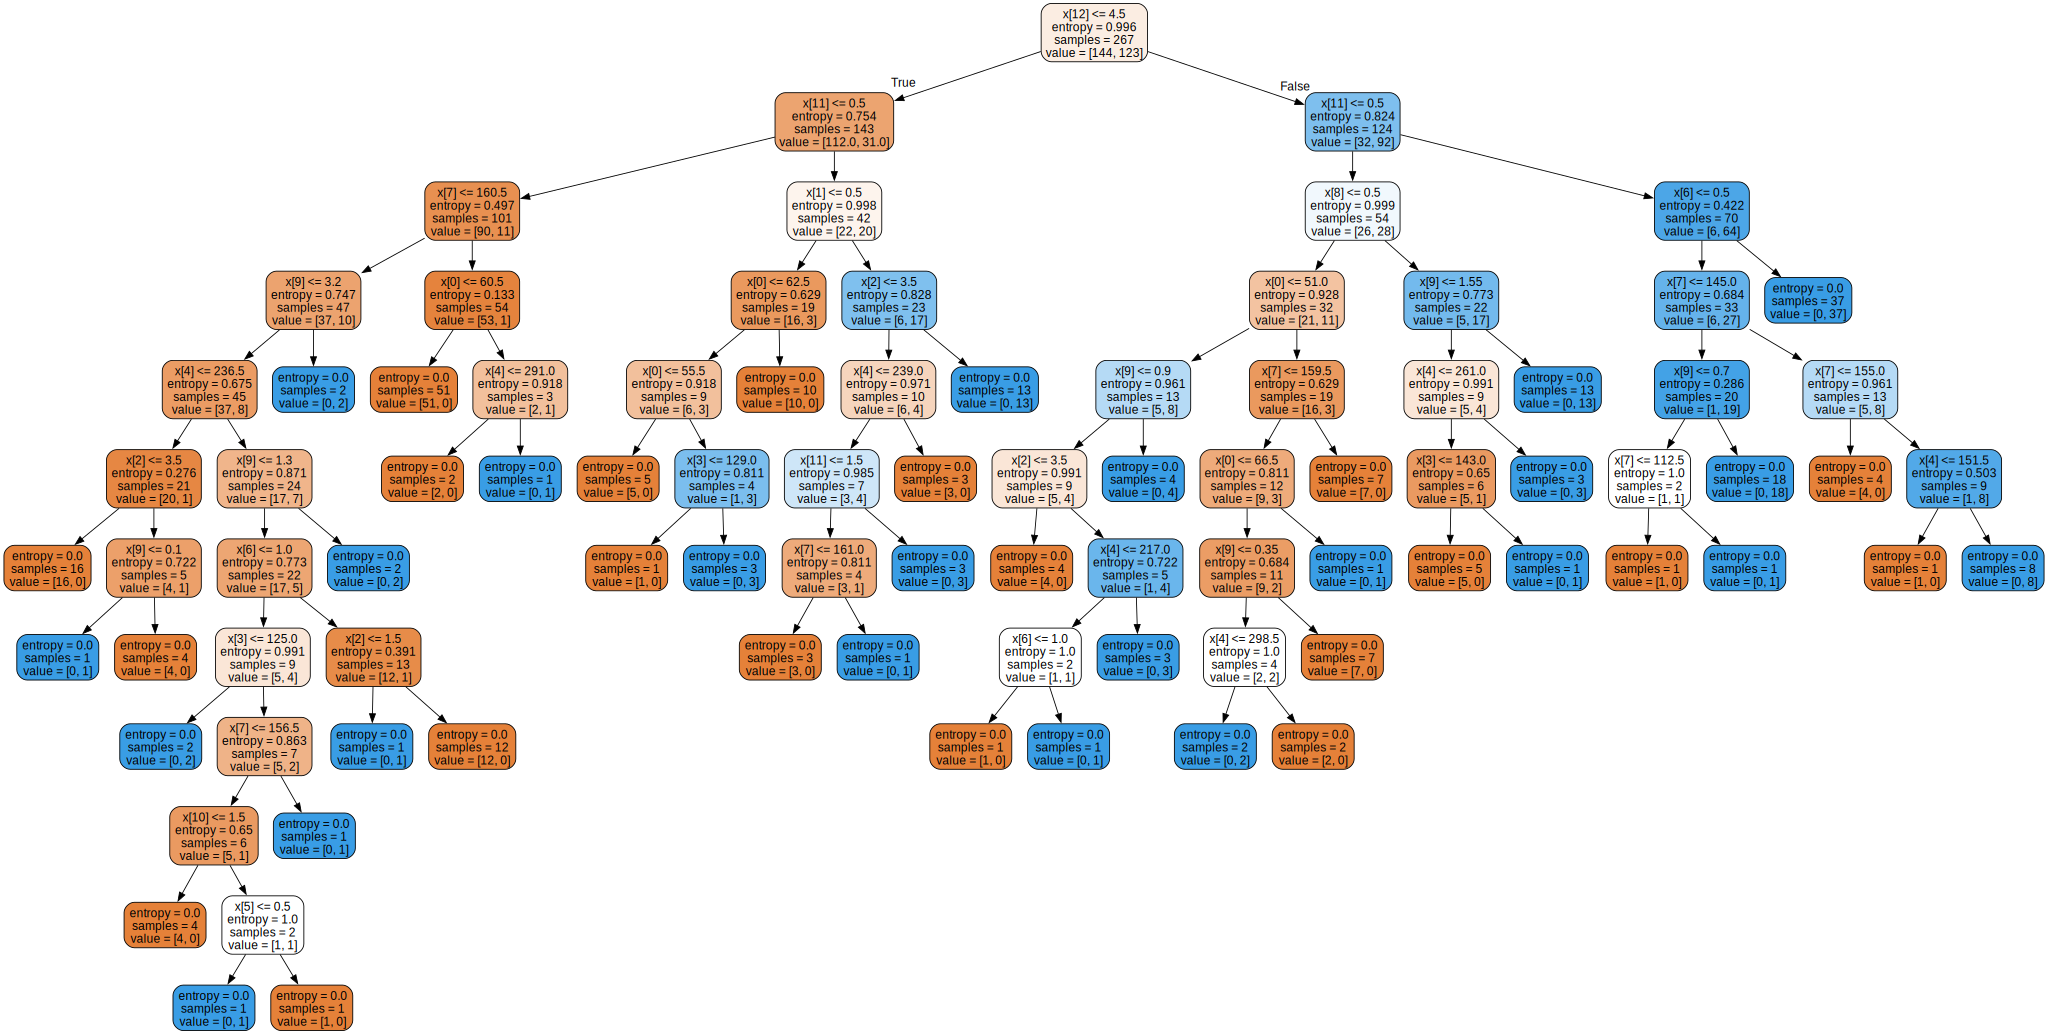

In [38]:
graphs['90/10']

### 3. Evaluating the Decision Tree Classifiers



In [ ]:
reports = {}
conf_matrices = {}

def evaluate_decision_tree_classifier(model, ratio):
    feature_test = datasets[ratio][1]
    label_test = datasets[ratio][3]

    label_predicted = model.predict(feature_test)

    report = classification_report(label_test, label_predicted, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df
    reports[ratio] = report_df

    conf_matrix = confusion_matrix(label_test, label_predicted)
    conf_matrices[ratio] = conf_matrix

def display_evaluation(ratio):
    print("Classification report -----------")
    display(reports[ratio].round(3))

    print("Confusion matrix ----------------")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrices[ratio], 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=np.unique(y), 
                yticklabels=np.unique(y))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for ratio, model in models.items():
    evaluate_decision_tree_classifier(model, ratio)

#### a. 40/60 Splitting

Classification report -----------


,precision,recall,f1-score,support
0,0.710,0.740,0.724,96.000
1,0.684,0.651,0.667,83.000
accuracy,0.698,0.698,0.698,0.698
macro avg,0.697,0.695,0.696,179.000
weighted avg,0.698,0.698,0.698,179.000


Confusion matrix ----------------


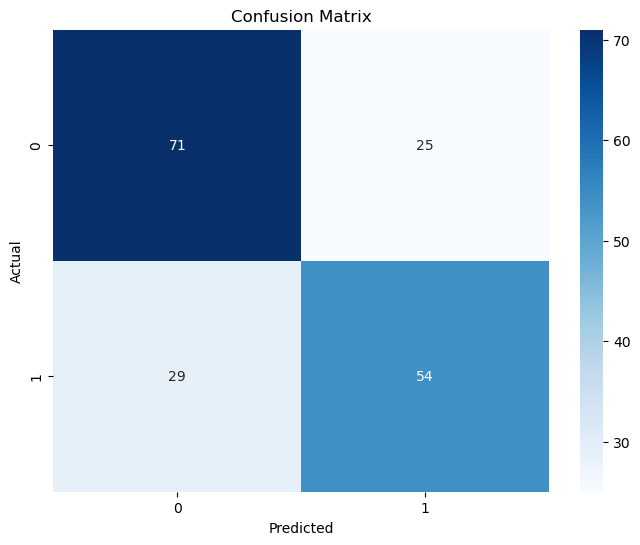

In [60]:
display_evaluation('40/60')

#### b. 60/40 Splitting

Classification report -----------


,precision,recall,f1-score,support
0,0.762,0.750,0.756,64.000
1,0.714,0.727,0.721,55.000
accuracy,0.739,0.739,0.739,0.739
macro avg,0.738,0.739,0.738,119.000
weighted avg,0.740,0.739,0.740,119.000


Confusion matrix ----------------


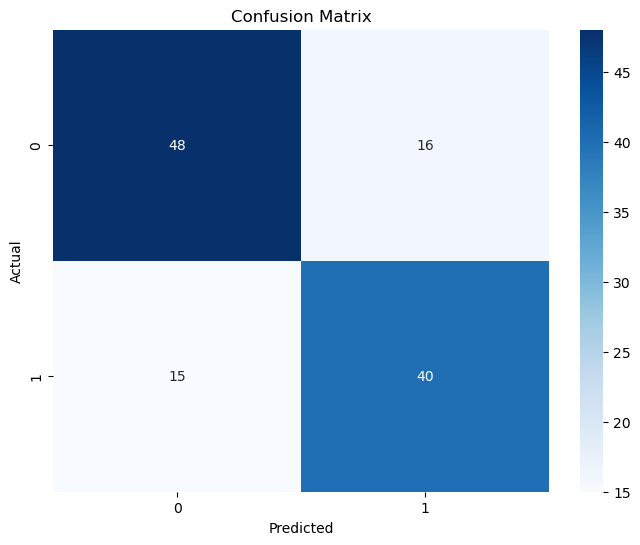

In [55]:
display_evaluation('60/40')

#### c. 80/20 Splitting

Classification report -----------


,precision,recall,f1-score,support
0,0.897,0.812,0.852,32.00
1,0.806,0.893,0.847,28.00
accuracy,0.850,0.850,0.850,0.85
macro avg,0.852,0.853,0.850,60.00
weighted avg,0.855,0.850,0.850,60.00


Confusion matrix ----------------


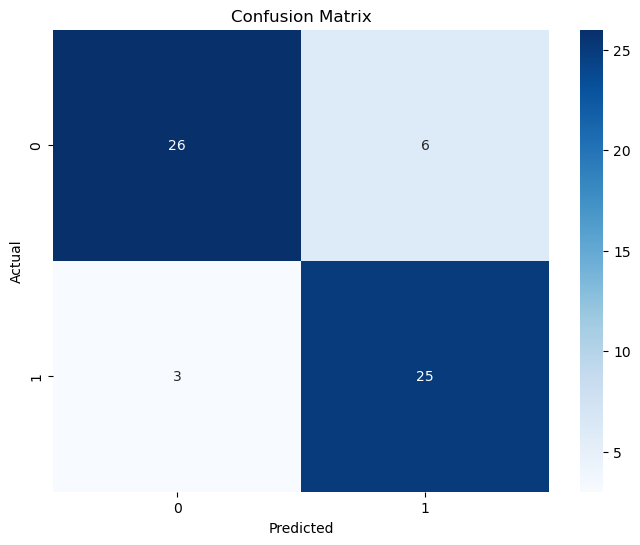

In [56]:
display_evaluation('80/20')

#### d. 90/10 Splitting

Classification report -----------


,precision,recall,f1-score,support
0,0.722,0.812,0.765,16.000
1,0.750,0.643,0.692,14.000
accuracy,0.733,0.733,0.733,0.733
macro avg,0.736,0.728,0.729,30.000
weighted avg,0.735,0.733,0.731,30.000


Confusion matrix ----------------


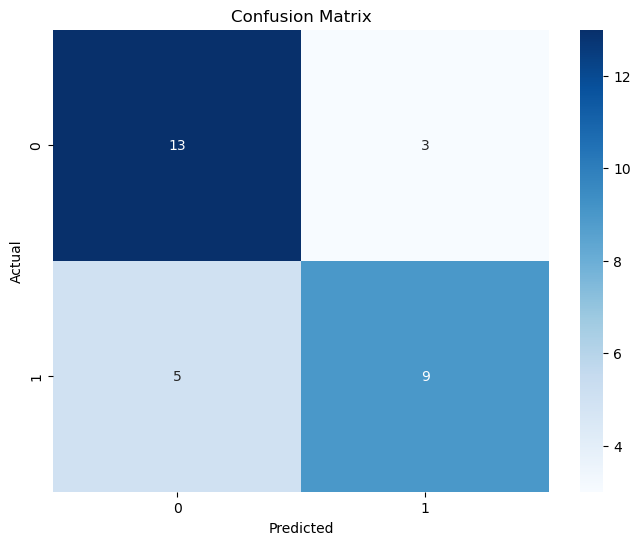

In [57]:
display_evaluation('90/10')

#### Overall Insights

### 4. The Depth and Accuracy of a Decision Tree (80/20 Splitting)